# Imports

In [2]:
#Community imports
import os
import numpy as np
import matplotlib.pyplot as plt
from descartes import PolygonPatch
from datetime import datetime
import geopandas as gpd

from shapely.geometry import MultiPolygon, MultiPoint, Point
import shapely.speedups
shapely.speedups.enable()

#pyWavlet imports
from snowradar import snowradar
from atm import atm
import picklayers

#Constants
crs= {'init': 'epsg:4326'}
density_snow = 0.300 #Density of snow on sea ice; See Alexandrov et al., 2010, The Cryosphere
perm_snow = (1 + 0.51 * density_snow) ** 3  #Density to permitivity
n_snow = np.sqrt(perm_snow) #Permitivity to refractive index
c = 299792458 #Vacuum speed of light

time_tolerance = 5 #ATM data time tollerence

C:\Users\kingj\AppData\Local\Continuum\anaconda3\envs\wavelet\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Load the available SR and ATM data

In [3]:
radar_dir= "./data/eureka/sr"
radar_path = []
radar_file = []
for file in os.listdir(radar_dir):
    if file.endswith(".mat"):
        radar_path.append(os.path.join(radar_dir, file))
        radar_file.append(file)

radar_meta = [snowradar(fp, l_case='meta') for fp in radar_path]
sr_meta_df = gpd.pd.DataFrame([x.as_dict() for x in radar_meta])
sr_meta_df = gpd.GeoDataFrame(sr_meta_df, crs=crs, geometry=sr_meta_df.poly)
sr_meta_df = sr_meta_df.drop(['poly'], axis=1)
sr_meta_df['atm_idx'] = None

In [4]:
atm_dir= "./data/eureka/atm"
atm_path = []
atm_file = []
for file in os.listdir(atm_dir):
    if file.endswith(".h5"):
        atm_path.append(os.path.join(atm_dir, file))
        atm_file.append(file)
atm_meta = [atm(fp, l_case='meta') for fp in atm_path]
atm_meta_df = gpd.pd.DataFrame([x.as_dict() for x in atm_meta])
atm_meta_df = gpd.GeoDataFrame(atm_meta_df, crs=crs, geometry=atm_meta_df.poly)
atm_meta_df = atm_meta_df.drop(['poly'], axis=1)

## Calculate the nearest time matches between the avilable ATM data and SR data files

In [7]:
for sr_index, sr_row in sr_meta_df.iterrows():
    time_diff = sr_row['tstart']-atm_meta_df['tstart']
    time_diff = time_diff[time_diff>0]
    if not time_diff.empty:
        t_idx = time_diff[time_diff>0].idxmin()
        if (sr_row['tend']>atm_meta_df.loc[t_idx]['tend']):
            #These are cases where the file crosses two ATM files
            #TODO load two atm files
            continue
        sr_meta_df.loc[sr_index,('atm_idx')] = t_idx
    
    radar_dat = snowradar(sr_row.fpath, l_case='full')
    atm_dat = atm(atm_meta_df.loc[sr_meta_df.atm_idx[t_idx],('fpath')], 'full')
    #radar_cur= snowradar(sr_meta_df.fpath[rdx], l_case='full')


TypeError: cannot use label indexing with a null key

## Example for one SR file

In [43]:
rdx = 30
radar_cur= snowradar(sr_meta_df.fpath[rdx], l_case='full')
atm_cur = atm(atm_meta_df.loc[sr_meta_df.atm_idx[rdx],('fpath')], 'full')

time_tolerance = 5 #in seconds
atm_idx = np.where(np.logical_and(atm_cur.time_utc>=radar_cur.time_utc[0]-time_tolerance, 
                                  atm_cur.time_utc<=radar_cur.time_utc[-1]+time_tolerance))

In [55]:
sr_df = gpd.pd.DataFrame({"lat":radar_cur.lat,
                          "lon":radar_cur.lon})
    
sr_geom = [Point(xy) for xy in zip(radar_cur.lon, radar_cur.lat)]
sr_df = gpd.GeoDataFrame(sr_df, crs=crs, geometry=sr_geom)
sr_df = sr_df.to_crs({'init': 'epsg:3413'})
#sr_df['buff'] = sr_df.geometry.buffer(50)
sr_df['geometry'] = sr_df.geometry.buffer(50)

In [57]:
sr_out = sr_df.to_crs({'init': 'epsg:32616'})
sr_df.to_file(driver = 'ESRI Shapefile', filename= "sr_df1.shp")
print(sr_df.crs)

{'init': 'epsg:3413'}


In [45]:
atm_df = gpd.pd.DataFrame({"lat":atm_cur.lat[atm_idx],
                          "lon":atm_cur.lon[atm_idx], 
                          "data":atm_cur.elv[atm_idx]})
atm_geom = [Point(xy) for xy in zip(atm_df.lon, atm_df.lat)]
atm_df = atm_df.drop(['lat', 'lon'], axis=1)
atm_df = gpd.GeoDataFrame(atm_df, crs=crs, geometry=atm_geom)
atm_df = atm_df.to_crs({'init': 'epsg:3413'})

In [46]:
atm_extract = gpd.sjoin(atm_df, sr_df, op='within') 

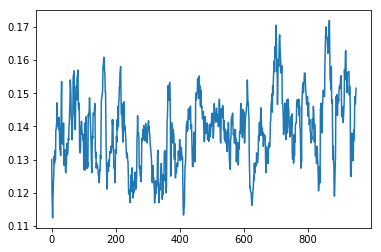

In [47]:
radar_cur.htopo = atm_extract.groupby('index_right')['data'].quantile(.95)-atm_extract.groupby('index_right')['data'].quantile(.5)
plt.plot(radar_cur.htopo)


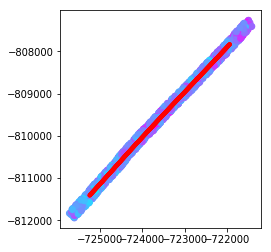

In [48]:
fig, ax = plt.subplots()
ax.set_aspect('equal')
atm_df.sample(1000).plot(ax=ax, column='data', cmap='cool')
sr_df.plot(ax=ax, color='red',  markersize=10)
plt.show();

In [49]:
radar_cur.calcpulsewidth()
print(radar_cur.epw)
print(radar_cur.n2n)
l_as,l_si = np.apply_along_axis(picklayers.picklayers, 0,radar_cur.data_radar,radar_cur.n2n,radar_cur.dfr,n_snow)

0.07570516616161617
0.20186025505333335


Mean snow depth (m): 0.25142605781198557


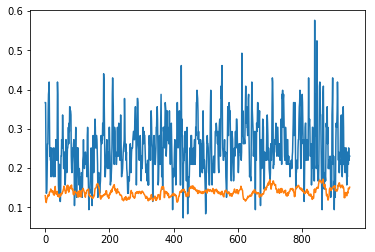

In [50]:
snow_depth = (l_si - l_as) * radar_cur.dfr / n_snow
print("Mean snow depth (m):", np.mean(snow_depth))
plt.plot(snow_depth);
plt.plot(radar_cur.htopo)

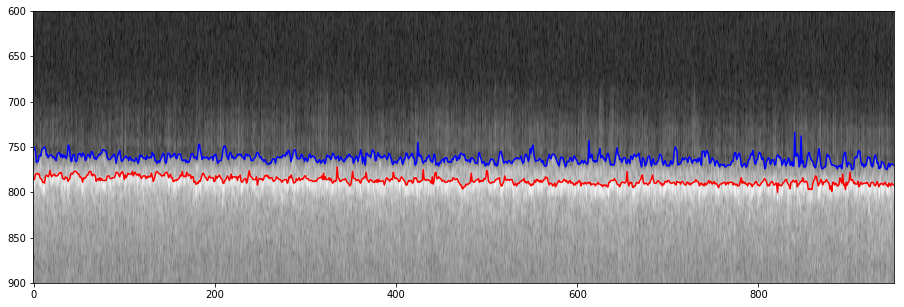

In [51]:
fig, ax = plt.subplots(figsize=(25,5))
ax.imshow(10 * np.log10(radar_cur.data_radar), interpolation='nearest', cmap="gist_gray")
ax.plot(l_si, color='r')
ax.plot(l_as, color='b')
ax.set_ylim([900, 600])
#ax2 = ax.twinx()
#ax2.plot(radar_cur.htopo, 'y.')
plt.show()